In [1]:
from ipynb.fs.full. plotting_tools import *
import os
import pickle


In [2]:
# Select RANS model
dataset = 'komegasst' 

labels = 'a_NL'
features_nut = 'eV'

parent_directory = 'D:\\OneDrive - Universidade de Lisboa\\Turbulence Modelling Database\\' + dataset

#basis_name = '4_basis_S_R_K_P' ### This file should be made redundant and everything should be moved to Turb_V_name, llke a working fields directory

Turb_V_name = 'a_3_1_2_NL_S_DNS_eV'
#'a_4_1_2_NL_Wu_47'
# 'Pope_a'

dataset = parent_directory + '\\' + Turb_V_name + '\\'+ dataset

#current_file = 'JLK9.0
#current_file = 'ev_TBNN_JLK11'
current_file = 'cross_OeV_TBNN_3b_ff'

### Setting up functions
cwd = Path.cwd()

In [3]:
class foam_2_file(object):
    '''
    2 utilizatons:
    1) Receives an anisotropy field (pre realizable) and extracts the eV from avg eV from both folds
       Outputs the NL part by substractin to a the eV*Shat term and writes it to semi_impliciti
       
       
    2) Receives the realizable anisotropy field and writes it to explicit
    '''
    def __init__(self, cases, full_pred_dict, current_file):
        
        self.cases = cases
        self.full_pred_dict = full_pred_dict
        self.current_file = current_file
        
        for case in cases:
            if not os.path.exists(f'foam_{case}'):
                # If it doesn't exist, create it
                try:
                    os.makedirs(f'foam_{case}_{self.current_file}//semi_implicit')
                    #os.makedirs(f'foam_{case}_{self.current_file}//explicit')
                    #os.makedirs(f'foam_{case}_{self.current_file}//explicit_DNS')
                except FileExistsError:
                    continue
        
        self.iterations = {
                           'BUMP': 6000,
                           'CNDV': 5000,
                           'PHLL': 20000        
                           }
        
        self.boundaries_dict = {
                               'top_bottom':{
                                             'PHLL': 'Wall',
                                             'BUMP': '',
                                             'CNDV': ''  
                                            },
                               'empty':     {
                                             'PHLL': 'defaultFaces',
                                             'BUMP': 'frontAndBack',
                                             'CNDV': 'frontAndBack'  
                                            },
                              'inlet_outlet':{
                                              'PHLL': 'cyclic',
                                              'BUMP': 'zeroGradient',
                                              'CNDV': 'zeroGradient'
                                             }
                               } 
        self.fixed_dict = {
                           'a' : '(0 0 0 0 0 0)',
                           'nut': '0'
                          }

    def foam_header(self, field_type, iterations, field):
        return f'''/*--------------------------------*- C++ -*----------------------------------*\\
| =========                 |                                                 |
| \\\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           |
|  \\\    /   O peration     | Version:  2006                                  |
|   \\\  /    A nd           | Website:  www.openfoam.com                      |
|    \\\/     M anipulation  |                                                 |
\*---------------------------------------------------------------------------*/
FoamFile
{{
    version     2.0;
    format      ascii;
    class       {field_type};
    location    "{iterations}";
    object      {field};
}}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //'''
    
    def create_boundaries(self, case, _id):
        return f'''
boundaryField
{{
    inlet
    {{
        type            {self.boundaries_dict['inlet_outlet'][case[:4]]};
    }}
    outlet
    {{
        type            {self.boundaries_dict['inlet_outlet'][case[:4]]};
    }} 
    top{self.boundaries_dict['top_bottom'][case[:4]]}
    {{
        type            fixedValue;
        value           uniform {self.fixed_dict[_id]};
    }}
    bottom{self.boundaries_dict['top_bottom'][case[:4]]}
    {{
        type            fixedValue;
        value           uniform {self.fixed_dict[_id]};
    }}
    {self.boundaries_dict['empty'][case[:4]]}
    {{
        type            empty;
    }}
}}
'''     
                
    def create_anisotropy(self,case, _identifier):
        '''
        (
        (xx xy xz yy yz zz)
        ...
        )
        '''
        anisotropy_header = f'''
        
dimensions      [0 2 -2 0 0 0 0];


internalField   nonuniform List<symmTensor>
{self.full_pred_dict[case][_identifier].shape[0]}
'''
        anisotropy_reg = '(\n'+'\n'.join([f'({anisotropy[0]} {anisotropy[1]} 0 {anisotropy[2]} 0  {anisotropy[3]})' for anisotropy in self.full_pred_dict[case][_identifier]])+'\n)\n;'
        ### do I need to add boundary field?
           
        anisotropy_bottom = '''\n\n// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //'''
        return anisotropy_header + anisotropy_reg + self.create_boundaries(case, 'a') + anisotropy_bottom
    
    def create_eV(self,case,implicit=True):
        eV_header = f'''
        
dimensions      [0 2 -1 0 0 0 0];


internalField   nonuniform List<scalar>
{self.full_pred_dict[case]['eV'].shape[0]}
'''
        eV_reg = '(\n'+'\n'.join([f'{viscosity if implicit else 0}' for viscosity in self.full_pred_dict[case]['eV']])+'\n)\n;'
        ### do I need to add boundary field?
        eV_bottom = '''\n\n// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //'''
        return eV_header + eV_reg + self.create_boundaries(case, 'nut') + eV_bottom
    
    def create_semi_implicit_files(self,case):
        ### generate nut_L
        ### calculate impçlicit b
        ### savc all
        with open(f'foam_{case}_{self.current_file}//semi_implicit//nut_L', 'w') as f:
            f.write(self.foam_header('volScalarField', self.iterations[case[:4]], 'nut_L') + self.create_eV(case))
            
        with open(f'foam_{case}_{self.current_file}//semi_implicit//aperp', 'w') as f:
            f.write(self.foam_header('volSymmTensorField', self.iterations[case[:4]], 'aperp') + self.create_anisotropy(case, 'a_NL'))
            
        return f'> Sucessfully wrote implicit files for {case}'
        #return 'in progress'
    
    def create_explicit_files(self, case):
        with open(f'foam_{case}_{self.current_file}//explicit//nut_L', 'w') as f:
            f.write(self.foam_header('volScalarField', self.iterations[case[:4]], 'nut_L') + self.create_eV(case, implicit=False))
            
        with open(f'foam_{case}_{self.current_file}//explicit//aperp', 'w') as f:
            f.write(self.foam_header('volSymmTensorField', self.iterations[case[:4]], 'aperp') + self.create_anisotropy(case, 'a'))
            
        with open(f'foam_{case}_{self.current_file}//explicit_DNS//nut_L', 'w') as f:
            f.write(self.foam_header('volScalarField', self.iterations[case[:4]], 'nut_L') + self.create_eV(case, implicit=False))
            
        with open(f'foam_{case}//explicit_DNS//aperp', 'w') as f:
           f.write(self.foam_header('volSymmTensorField', self.iterations[case[:4]], 'aperp') + self.create_anisotropy(case, 'a_DNS'))
            
        return f'> Sucessfully wrote explicit files for {case}'
    
    def replace_viscosity_implicit(self):
        for case in self.cases:
            with open(f'foam_{case}_{self.current_file}//semi_implicit//nut_L', 'w') as f:
                f.write(self.foam_header('volScalarField', self.iterations[case[:4]], 'nut_L') + self.create_eV(case))

    
    def generate_case_files(self):
        for case in self.cases:
            print(self.create_semi_implicit_files(case))
            print('\n')
        print('> Sucessfully generated all files')
        

def load_files_from_folder(folder_path):
    """Loads the contents of all files within a given folder.

    Args:
        folder_path (str): The path to the folder containing the files.

    Returns:
        list: A list of file contents, where each element is the content of a file.
    """

    file_contents = {}
    for filename in os.listdir(folder_path):
        print(filename)
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            try:
                with open(file_path, "rb") as file:
                    _dict = pickle.load(file)
                    file_contents[filename[:-4]]=_dict
            except (IOError, OSError) as e:
                print(f"Error reading file '{filename}': {e}")
                # Handle errors gracefully, e.g., log or skip the file

    return file_contents

In [4]:
pred_dicts = load_files_from_folder(os.path.join(cwd, 'folds_dict'))


case = 'PHLL_case_1p2'

[Cx, Cy] = load_coordinates([case], 'komegasst')

a_NL_labels = loadCombinedArray_Turb_V([case], 'a_NL', dataset)

eV_labels = loadCombinedArray_Turb_V([case], 'eV', dataset)

a_NL_pred_dict = {case: 0.5*pred_dicts[f'a_NL_f1'][case]+0.5*pred_dicts[f'a_NL_f2'][case]}
eV_pred_dict = {case: 0.5*pred_dicts[f'eV_f1'][case]+0.5*pred_dicts[f'eV_f2'][case]}

a_NL_f1.pkl
a_NL_f2.pkl
eV_f1.pkl
eV_f2.pkl


In [5]:
full_pred_dict = {case:{
                        'eV': eV_pred_dict[case],
                        'a_NL': a_NL_pred_dict[case]
                       }}

foam_2_file([case], full_pred_dict, 'NL_3b_ff').generate_case_files()
foam_2_file([case], {case:{
                        'eV': eV_labels[:,0],
                        'a_NL':a_NL_labels}}, 'NL_3b_ff_eVTBNN').generate_case_files()

> Sucessfully wrote implicit files for PHLL_case_1p2


> Sucessfully generated all files
> Sucessfully wrote implicit files for PHLL_case_1p2


> Sucessfully generated all files



====== labels_a_11 ======
> mean absolute error = 1.080117271306791e-06
> mean squared error = 2.873576353475077e-12
> mean r2 score = 0.913

====== labels_a_12 ======
> mean absolute error = 9.140780786144903e-07
> mean squared error = 2.2688124247060493e-12
> mean r2 score = 0.851

====== labels_a_22 ======
> mean absolute error = 1.097946310420541e-06
> mean squared error = 2.9794336307906476e-12
> mean r2 score = 0.852

====== labels_a_33 ======
> mean absolute error = 6.790113079138964e-07
> mean squared error = 1.055842186150594e-12
> mean r2 score = 0.959

====== PHLL_case_1p2 a_NL Overall Metrics ======
> mean absolute error = 9.427882420639296e-07
> mean squared error = 2.294416148780592e-12
> r2 score = 0.894


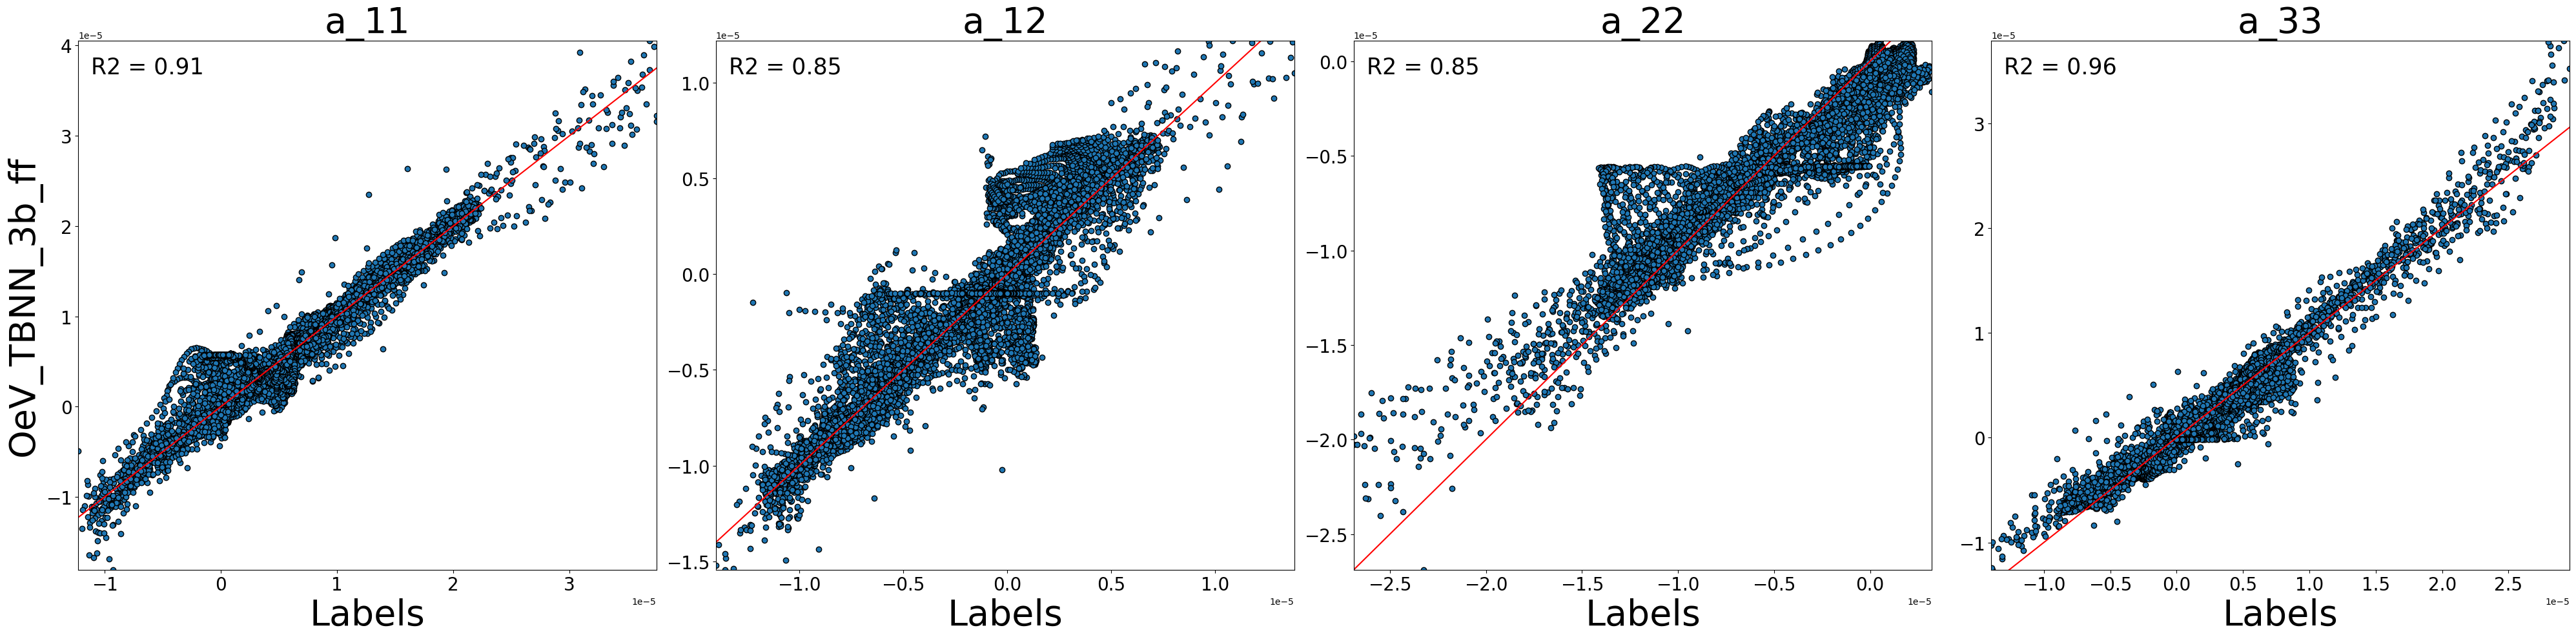

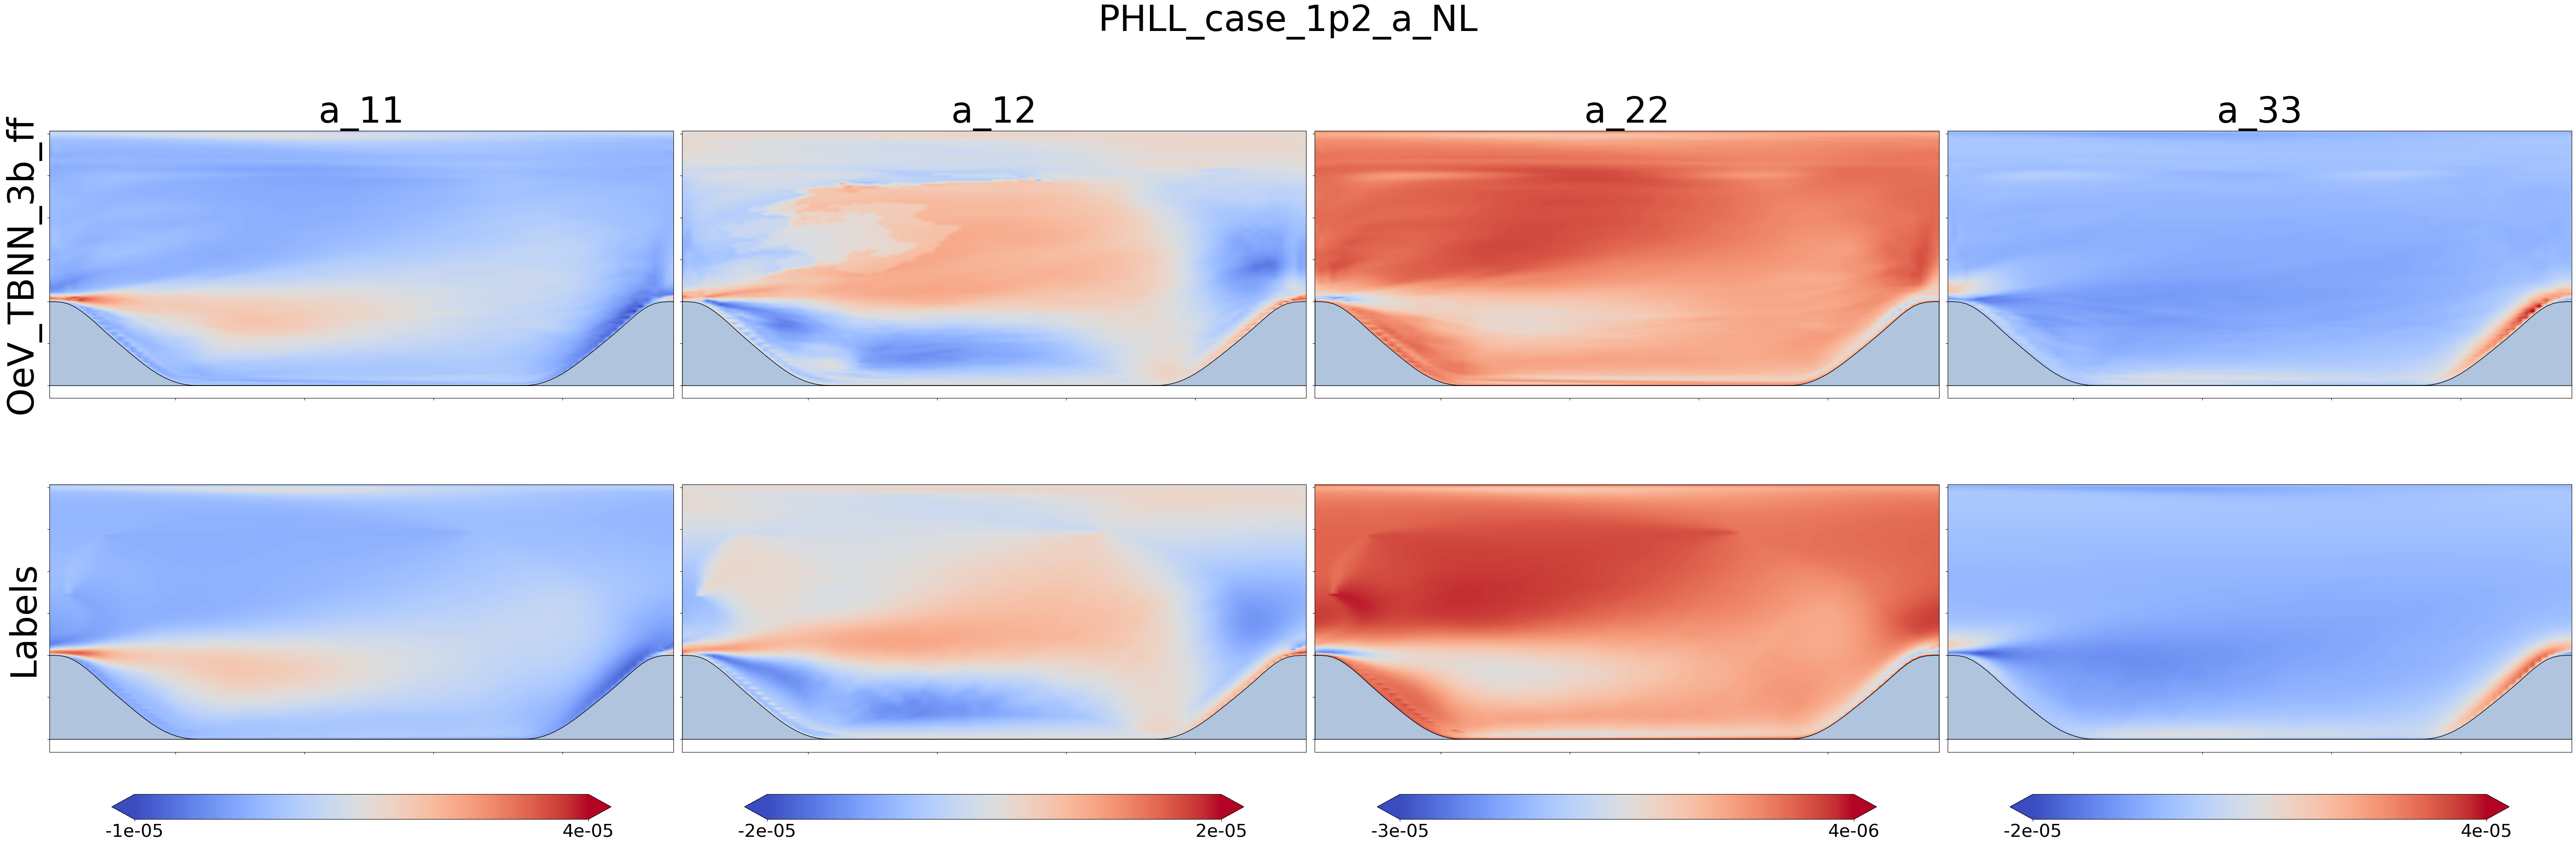

In [6]:
get_parity_plots(a_NL_pred_dict[case], a_NL_labels, f'{case}_a_NL', current_file[6:], '')
get_plots(a_NL_pred_dict[case], a_NL_labels, Cx, Cy, case, current_file[6:], f'{case}_a_NL')

print(f'\n====== {case} a_NL Overall Metrics ======')
print(f'> mean absolute error = {mean_absolute_error(a_NL_labels, a_NL_pred_dict[case])}')
print(f'> mean squared error = {mean_squared_error(a_NL_labels, a_NL_pred_dict[case])}')
print(f'> r2 score = {r2_score(a_NL_labels, a_NL_pred_dict[case]):.3f}')


====== PHLL_case_1p2 eVMetrics ======
> mean absolute error = 0.0005375214154470132
> mean squared error = 1.041852076844375e-06
> r2 score = -0.406


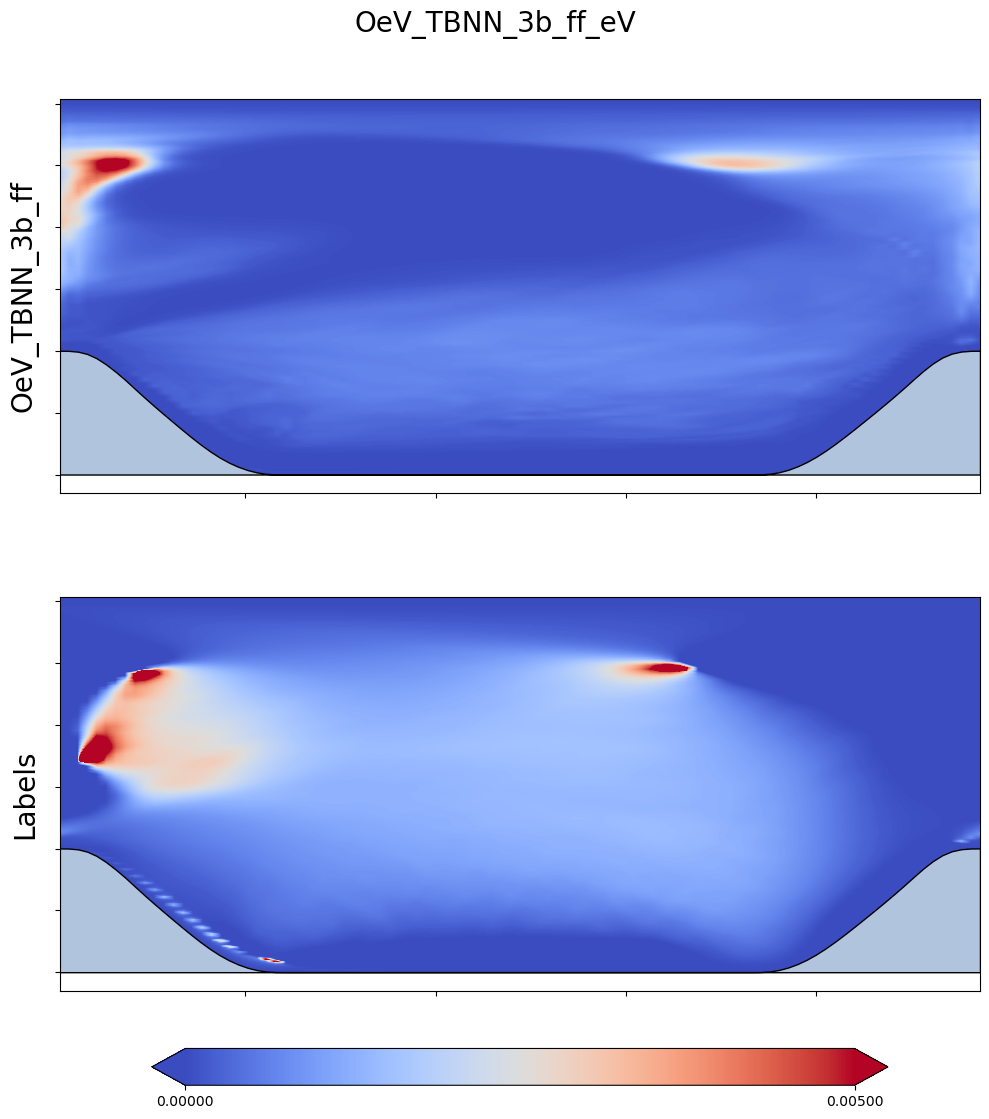

In [7]:
eV_plot(eV_pred_dict[case], eV_labels, Cx, Cy, case, current_file[6:])
print(f'\n====== {case} eVMetrics ======')
print(f'> mean absolute error = {mean_absolute_error(eV_labels, eV_pred_dict[case])}')
print(f'> mean squared error = {mean_squared_error(eV_labels, eV_pred_dict[case])}')
print(f'> r2 score = {r2_score(eV_labels, eV_pred_dict[case]):.3f}')